In [128]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [129]:
# Test URLs and requests with 1 or 2 URLs...

url_1 = 'https://www.pro-football-reference.com/players/J/JackLa00.htm'
url_2 = 'https://www.pro-football-reference.com/players/W/WarnKu00.htm'
url_3 = 'https://www.pro-football-reference.com/players/B/BartSt00.htm'
# GET request to the URL
response = requests.get(url_1)
tables = {}
# Check if the request was successful
if response.status_code == 200:
    # Parse HTML content with BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    # Find all tables in the HTML content, print the number found.
    tables = soup.find_all('table')
    print(f"Number of tables found: {len(tables)}")

    # Iterate over all tables and print a snippet to identify the correct one
    for i, table in enumerate(tables):
        print(f"\nTable {i}:")
        print(table.prettify()[:1000])  # Print snippet of table
else:
    print(f"Failed to fetch the webpage. Status code: {response.status_code}")



Number of tables found: 15

Table 0:
<table class="sortable stats_table" data-cols-to-freeze=",1" id="last5">
 <caption>
  2024 Game Logs Table
 </caption>
 <colgroup>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
  <col/>
 </colgroup>
 <thead>
  <tr class="over_header">
   <th aria-label="" class="over_header center" colspan="5" data-stat="">
   </th>
   <th aria-label="" class="over_header center" colspan="18" data-stat="header_pass">
    Passing
   </th>
   <th aria-label="" class="over_header center" colspan="5" data-stat="header_rush">
    Rushing
   </th>
   <th>
   </th>
  </tr>
  <tr>
   <th aria-label="Date" class="poptip center" data-stat="date" scope="col">
    Date
   </th>
   <th aria-label="Team" class="poptip center" data-stat="team_name_abbr" scope="col">
    Team
   

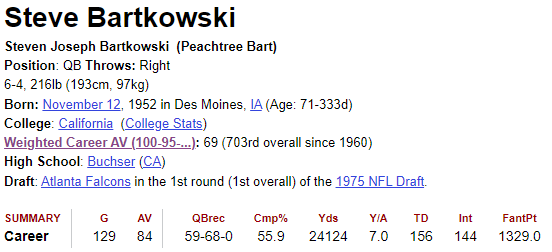




### Data Summary

div id="info" class="players" holds all data, then the following sections:

1.  div id = "meta"    
The players meta data can be found here:  <example data for this URL>
name <Steve Bartkowski>, nickname <Peachtree Bart>, Throws <Right>
height <6-4>, weight  <216lb>, born_date <1952-11-12> or after the birthdays.cgi: <November 12, 1952>
born_location <Des Moines, IA>, college <California>, highschool  <>, draft  <>

2. after div#meta closes, new section, with id="bling"
li class="all_star", Href for: probowl, awards
'Recognition' header: all_star; 'Uniforms' data header: uniforms

3.  the final section follows span with a strong SUMMARY header.  Would like the following data as variables pulled out here:
G, AV, QBrec, Cmp%, Yds, Y/A, TD, Int, FantPt

In [130]:
def get_recognition(soup):
    recognition_data = {}
    try:
        bling = soup.find('ul', id='bling')
        recognition_data['all_star'] = [li.get_text(strip=True) for li in bling.find_all('li', class_='all_star')]
        recognition_data['uniforms'] = [a['data-tip'] for a in soup.find('div', class_='uni_holder').find_all('a')]
    except AttributeError:
        recognition_data = {key: "N/A" for key in ['all_star', 'uniforms']}
    return recognition_data

def get_summary_stats(soup):
    summary_stats = {}
    try:
        summary = soup.find('div', {'class': 'stats_pullout'})
        summary_stats['games_played'] = summary.find('span', string='G').find_next('p').text.strip()
        summary_stats['approximate_value'] = summary.find('span', string='AV').find_next('p').text.strip()
        summary_stats['qb_record'] = summary.find('span', string='QBrec').find_next('p').text.strip()
        summary_stats['completion_percentage'] = summary.find('span', string='Cmp%').find_next('p').text.strip()
        summary_stats['passing_yards'] = summary.find('span', string='Yds').find_next('p').text.strip()
        summary_stats['yards_per_attempt'] = summary.find('span', string='Y/A').find_next('p').text.strip()
        summary_stats['touchdowns'] = summary.find('span', string='TD').find_next('p').text.strip()
        summary_stats['interceptions'] = summary.find('span', string='Int').find_next('p').text.strip()
        summary_stats['fantasy_points'] = summary.find('span', string='FantPt').find_next('p').text.strip()
    except AttributeError:
        summary_stats = {key: "N/A" for key in ['games_played', 'approximate_value', 'qb_record', 'completion_percentage', 'passing_yards', 'yards_per_attempt', 'touchdowns', 'interceptions', 'fantasy_points']}
    return summary_stats

In [131]:
import re

def get_faq(soup):
    faq_data = {}
    keyword_patterns = {
        'when_born': re.compile(r'when.*born', re.IGNORECASE),
        'where_born': re.compile(r'where.*born', re.IGNORECASE),
        'height': re.compile(r'tall', re.IGNORECASE),
        'weight': re.compile(r'weigh', re.IGNORECASE),
        'games_played': re.compile(r'games.*play', re.IGNORECASE),
        'pass_yards': re.compile(r'passing.*yards', re.IGNORECASE),
        'TD': re.compile(r'touchdowns', re.IGNORECASE),
        'superbowls': re.compile(r'Super Bowls', re.IGNORECASE),
        'retire_year': re.compile(r'retire', re.IGNORECASE),
        'nickname': re.compile(r'nicknames', re.IGNORECASE)
    }

    try:
        faq = soup.find('div', id='div_faq')
        for key, pattern in keyword_patterns.items():
            question = faq.find('h3', string=pattern)
            if question:
                answer = question.find_next('p').text
                if key in ['when_born', 'where_born']:
                    faq_data[key] = re.split(r'on | in ', answer)[-1].strip('.')
                elif key == 'height':
                    faq_data[key] = re.search(r'\d+-\d+', answer).group()
                elif key == 'weight':
                    faq_data[key] = re.search(r'\d+ lbs', answer).group().split()[0]
                elif key == 'superbowls':
                    faq_data[key] = re.search(r'\d+', answer) and re.search(r'\d+', answer).group() or '0'
                elif key in ['games_played', 'pass_yards', 'TD']:
                    faq_data[key] = re.search(r'\d+', answer.replace(',', '')).group()
                elif key == 'retire_year':
                    faq_data[key] = re.search(r'\d+', answer).group()
                elif key == 'nickname':
                    faq_data[key] = re.split(r' is a nickname| are nicknames', answer)[0]
                else:
                    faq_data[key] = answer
    except AttributeError as e:
        print(f"An error occurred: {e}")
    return faq_data

In [132]:
import re

def get_qb_header_data(soup):
    qb_header_data = {
        'throws': '', 'hall_of_fame': '', 'college': '', 'high_school': '',
        'weighted_career_av': '', 'college_stats': '', 'draft_team': '',
        'draft_round': '', 'draft_pick': '', 'draft_year': ''    }

    try:
        # Extract Throws
        throws_tag = soup.find('strong', string='Throws:')
        if throws_tag and throws_tag.next_sibling:
            qb_header_data['throws'] = throws_tag.next_sibling.strip()

        # Extract College
        college_tag = soup.find('strong', text='College')
        if college_tag:
            college = college_tag.find_next('a')
            if college:
                qb_header_data['college'] = college.text.strip()

        # Extract College Stats URL
        college_stats_tag = soup.find('a', href=re.compile(r'https://www.sports-reference.com/cfb/players/'))
        if college_stats_tag:
            qb_header_data['college_stats'] = college_stats_tag['href']

        # Extract Weighted Career AV (wAV)
        wav_tag = re.search(r'Weighted Career AV.*?(\d+)', str(soup))
        if wav_tag:
            qb_header_data['weighted_career_av'] = wav_tag.group(1)

        # Extract High School
        high_school_tag = soup.find('strong', text='High School')
        if high_school_tag:
            high_school = high_school_tag.find_next('a')
            if high_school:
                qb_header_data['high_school'] = high_school.text.strip()

        # Extract Hall of Fame year (hof)
        hof_tag = re.search(r'Hall of Fame.*?(\d{4})', str(soup))
        if hof_tag:
            qb_header_data['hall_of_fame'] = hof_tag.group(1)

        # Extract Draft Team, Round, Pick, and Year
        draft_team_tag = re.search(r'Draft.*?<a.*?>(.*?)</a>', str(soup))
        if draft_team_tag:
            qb_header_data['draft_team'] = draft_team_tag.group(1)

        draft_round_tag = re.search(r'in the (\d+)(?:st|nd|rd|th) round', str(soup))
        if draft_round_tag:
            qb_header_data['draft_round'] = draft_round_tag.group(1)

        draft_pick_tag = re.search(r'\((\d+)(?:st|nd|rd|th) overall\)', str(soup))
        if draft_pick_tag:
            qb_header_data['draft_pick'] = draft_pick_tag.group(1)

        draft_year_tag = re.search(r'(\d{4}) NFL Draft', str(soup))
        if draft_year_tag:
            qb_header_data['draft_year'] = draft_year_tag.group(1)

    except AttributeError as e:
        print(f"An error occurred: {e}")

    return qb_header_data

In [133]:
import requests
from bs4 import BeautifulSoup

def get_soup(url):
    response = requests.get(url)
    if response.status_code == 200:
        return BeautifulSoup(response.content, 'html.parser')
    else:
        print(f"Failed to retrieve webpage. Status code: {response.status_code}")
        return None

url = "https://www.pro-football-reference.com/players/M/MannPe00.htm"

soup = get_soup(url)
if soup:
    qb_header_data = get_qb_header_data(soup)
    summary_stats = get_summary_stats(soup)
    recognition_data = get_recognition(soup)
    faq_data = get_faq(soup)
    print("")
    print("qb_header_data:", qb_header_data)
    print("Summary Stats:", summary_stats)
    print("Recognition:", recognition_data)
    print("FAQ Data:", faq_data)
    print("")
else: 
    print('no soup for you.')

import pprint
# Create a PrettyPrinter instance
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(qb_header_data)

C:\Users\black\AppData\Local\Temp\ipykernel_18864\4017800806.py:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  college_tag = soup.find('strong', text='College')
C:\Users\black\AppData\Local\Temp\ipykernel_18864\4017800806.py:33: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  high_school_tag = soup.find('strong', text='High School')



qb_header_data: {'throws': 'Right', 'hall_of_fame': '2000', 'college': 'Tennessee', 'high_school': 'Isidore Newman', 'weighted_career_av': '100', 'college_stats': 'https://www.sports-reference.com/cfb/players/peyton-manning-1.html', 'draft_team': 'Indianapolis Colts', 'draft_round': '1', 'draft_pick': '1', 'draft_year': '1998'}
Summary Stats: {'games_played': '266', 'approximate_value': '271', 'qb_record': '186-79-0', 'completion_percentage': '65.3', 'passing_yards': '71940', 'yards_per_attempt': '7.7', 'touchdowns': '539', 'interceptions': '251', 'fantasy_points': '4686.3'}
Recognition: {'all_star': ['14x Pro Bowl', '7x All-Pro'], 'uniforms': ['Indianapolis Colts 1998-2010', 'Denver Broncos 2012-2015']}
FAQ Data: {'when_born': 'March 24, 1976', 'where_born': 'New Orleans, LA', 'height': '6-5', 'weight': '230', 'games_played': '266', 'pass_yards': '71940', 'TD': '539', 'superbowls': '2', 'retire_year': '2015', 'nickname': 'The Sheriff, The Caveman, Peydirt'}

{   'college': 'Tennessee

In [134]:
# TESTING 

# Testing with a couple of URLs

import pprint
url = "https://www.pro-football-reference.com/players/B/BartSt00.htm"
url2 = "https://www.pro-football-reference.com/players/W/WarnKu00.htm"


soup = get_soup(url)
if soup:
    qb_header_data = get_qb_header_data(soup)#copilot
else: 
    print('no soup for you.')  

print(f"\nurl1  {url}")
# Create a PrettyPrinter instance
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(qb_header_data)

soup = get_soup(url2)
if soup:
    qb_header_data = get_qb_header_data(soup)
else: 
    print('no soup for you.')  

print(f"\nurl2  {url2}")
# Create a PrettyPrinter instance
pp = pprint.PrettyPrinter(indent=4)
print("\nver 1")
pp.pprint(qb_header_data)

C:\Users\black\AppData\Local\Temp\ipykernel_18864\4017800806.py:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  college_tag = soup.find('strong', text='College')
C:\Users\black\AppData\Local\Temp\ipykernel_18864\4017800806.py:33: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  high_school_tag = soup.find('strong', text='High School')



url1  https://www.pro-football-reference.com/players/B/BartSt00.htm
{   'college': 'California',
    'college_stats': 'https://www.sports-reference.com/cfb/players/steve-bartkowski-1.html',
    'draft_pick': '1',
    'draft_round': '1',
    'draft_team': 'Atlanta Falcons',
    'draft_year': '1975',
    'hall_of_fame': '8842',
    'high_school': 'Buchser',
    'throws': 'Right',
    'weighted_career_av': '100'}

url2  https://www.pro-football-reference.com/players/W/WarnKu00.htm

ver 1
{   'college': 'Northern Iowa',
    'college_stats': '',
    'draft_pick': '',
    'draft_round': '',
    'draft_team': 'Draft History',
    'draft_year': '',
    'hall_of_fame': '1999',
    'high_school': 'Regis',
    'throws': 'Right',
    'weighted_career_av': '100'}


In [146]:
# Sample URL for a player page : Kurt Warner, https://www.pro-football-reference.com/players/W/WarnKu00.htm

base_url = "https://www.pro-football-reference.com/players/"
suffix_url = "00.htm"

def create_url(name):
    '''function to build the following url from the name passed in:
    name_link=  <first letter of last name> / <first four letters of last name><first two letters of first name>
    eg.  Kurt Warner --> W/WarnKu'''

    try:
        # Remove apostrophes from the name
        name = name.replace("'", "")
        
        # Split the name into parts
        name_parts = name.split()

        # Ensure there are at least two parts (first name and last name)
        if len(name_parts) < 2:
            raise ValueError("Name must contain at least a first and last name")

        # The first part is the first name, and the last part is the last name
        first_name = name_parts[0]
        
        # Combine all parts of the last name (if there are multiple parts)
        last_name = ''.join(name_parts[1:])

        # The directory is based on the first letter of the last name
        directory_letter = last_name[0].upper()

        # Ensure the last name has at least 4 characters to avoid index errors
        if len(last_name) < 4:
            raise ValueError("Last name must have at least 4 characters for URL creation")

        # Create the name link using the first four letters of the last name and the first two letters of the first name
        name_link = f"{last_name[:4]}{first_name[:2]}"

        # Build the final URL
        url = f"https://www.pro-football-reference.com/players/{directory_letter}/{name_link}00.htm"

        return url

    except (IndexError, ValueError) as e:
        # In case of any error, return a placeholder or error message
        print(f"Error generating URL for '{name}': {e}")
        return "https://www.pro-football-reference.com/players/Unknown/Unknown00.htm"

name_list = ["Steve Deberg",      # Expected: players/D/DebeSt00.htm
                "Norman Van Broklin",  # Expected: VanBroNo
                "Kurt Warner",         # Expected: WarnKu
                "Ken O'Brien",     # Expected: players/O/OBriKe00.htm
                "John Smith"]           # Expected: SmitJo 

for name in name_list: 
    print(create_url(name))



https://www.pro-football-reference.com/players/D/DebeSt00.htm
https://www.pro-football-reference.com/players/V/VanBNo00.htm
https://www.pro-football-reference.com/players/W/WarnKu00.htm
https://www.pro-football-reference.com/players/O/OBriKe00.htm
https://www.pro-football-reference.com/players/S/SmitJo00.htm


In [147]:
# get lists of QBs to get data for:
rel_path = "../Data_Artifacts/nfl_career_statistics.csv"
qb_name_df = pd.read_csv(rel_path)
print(len(qb_name_df))

qb_name_df.head()

# import os
# absolute_path = os.path.abspath(rel_path)
# print(f"Absolute path: {absolute_path}")

# # Check if the file exists and open it with the default application
# if os.path.exists(absolute_path):
#     os.startfile(absolute_path)
#     print('Opened with default application.')
# else:
#     print(f'File not found at: {absolute_path}')


637


,player,drafted,yrs_played,teams,hof,wAV,earnings_mils,comp_%,pass_rating,comp,att,pass_yds,TD,pass_yds_game,int,int_%,pick_6,sacks,4QC,GWD
0,Tom Brady,2000.0,23.0,"['Patriots', 'Buccaneers']",0.0,184.0,317.620,64.3,97.2,7753.0,12050.0,89214.0,649.0,266.0,212.0,1.8,18.0,565.0,46.0,58.0
1,Drew Brees,2001.0,20.0,"['Saints', 'Chargers']",0.0,167.0,273.933,67.7,98.7,7142.0,10551.0,80358.0,571.0,280.0,243.0,2.3,27.0,420.0,36.0,53.0
2,Peyton Manning,1998.0,18.0,"['Colts', 'Broncos']",1.0,176.0,247.714,65.3,96.5,6125.0,9380.0,71940.0,539.0,270.0,251.0,2.7,27.0,303.0,43.0,54.0
3,Brett Favre,1991.0,20.0,"['Packers', 'Vikings', 'Jets', 'Falcons']",1.0,158.0,141.407,62.0,86.0,6300.0,10169.0,71838.0,508.0,237.0,336.0,3.3,32.0,525.0,28.0,43.0
4,Ben Roethlisberger,2004.0,18.0,['Steelers'],0.0,131.0,266.724,64.4,93.5,5440.0,8443.0,64088.0,418.0,257.0,211.0,2.5,18.0,554.0,41.0,53.0


### GET values from 4 dictionaries (qb_header_data, summary_stats, recognition_data, faq_data), 
based on different sections of the webpage.  
Merge these 4 dictionaries of data into single nested dictionary, 
with values flattened under one key (player's name) (not as sub-dictionaries).

### LOOP tahrough each entry and make an entry in the quarterback_dict

In [138]:


# Break the list into sections
first_10 = qb_list[:10]          # First 10 entries
to_20 = qb_list[10:20]         # Next 10 entries (from index 10 to 19)
to_50 = qb_list[20:50]         # Next 30 entries (from index 20 to 49)
to_100 = qb_list[50:100]        # Next 50 entries (from index 50 to 99)
to_200 = qb_list[100:200]         
to_300 = qb_list[200:300]         
to_400 = qb_list[300:400]        
to_500 = qb_list[400:500]         
to_600 = qb_list[500:600]       
to_end = qb_list[600:]  

637


In [139]:

#  merge Values from 4 dictionaries (qb_header_data, summary_stats, recognition_data, faq_data) into single nested dictionary, 
#  with values flattened under one key (player's name).  (Not as sub-dictionaries).
                                      
# loop through each name, get the values from the sub-dictionaries, and populate 
# an entry in the quarterback_dict with their entry 

import time
# Currently we will block users sending requests to: (locked out up to a day.)
#   FBref/Stathead sites > 10 requests/minute (need wait time of over 6 seconds)
#   Other sites > 20 req/min. (need wait time longer than 3 seconds)
# Regardless of bot type/construction/pages accessed.

# qb_list = ['Steven Bartkowski', 'Tom Brady', 'Drew Brees', 'Peyton Manning', 
#           'Brett Favre', 'Steve Deberg', 'Norman Van Broklin', 'Kurt Warner', "Ken O'Brien",  'John Smith']
quarterback_dict = {}
quarterback_fails = []
qb_list = qb_name_df['player'].tolist()
print(len(qb_list))


def merge_player_data(name):
    player_data = {}
    # Combine data from each dictionary into player_data dictionary
    player_data.update(qb_header_data)       # Add QB header data
    player_data.update(summary_stats)         # Add summary stats
    player_data.update(recognition_data)      # Add recognition data
    player_data.update(faq_data)              # Add FAQ data

    # Store the player_data dictionary in the quarterback_dict, with player's name as key
    quarterback_dict[name] = player_data

for name in qb_list:       #first_10
    print(f'player {name}')
    time.sleep(10)
    soup = get_soup(create_url(name))
    if soup:
        qb_header_data = get_qb_header_data(soup)
        summary_stats = get_summary_stats(soup)
        recognition_data = get_recognition(soup)
        faq_data = get_faq(soup)
        print("qb_header_data:", qb_header_data)
        print("Summary Stats:", summary_stats)
        print("Recognition:", recognition_data)
        print("FAQ Data:", faq_data)
        print("")
        merge_player_data(name)
    else: 
        quarterback_fails.append(name)     
        print(f'no soup for you, {name}')  
        print("")



player Tom Brady


C:\Users\black\AppData\Local\Temp\ipykernel_18864\4017800806.py:16: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  college_tag = soup.find('strong', text='College')
C:\Users\black\AppData\Local\Temp\ipykernel_18864\4017800806.py:33: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  high_school_tag = soup.find('strong', text='High School')


qb_header_data: {'throws': 'Right', 'hall_of_fame': '2000', 'college': 'Michigan', 'high_school': 'Junipero Serra', 'weighted_career_av': '100', 'college_stats': 'https://www.sports-reference.com/cfb/players/tom-brady-1.html', 'draft_team': 'New England Patriots', 'draft_round': '6', 'draft_pick': '199', 'draft_year': '2000'}
Summary Stats: {'games_played': '335', 'approximate_value': '326', 'qb_record': '251-82-0', 'completion_percentage': '64.3', 'passing_yards': '89214', 'yards_per_attempt': '7.4', 'touchdowns': '649', 'interceptions': '212', 'fantasy_points': '5943.4'}
Recognition: {'all_star': ['15x Pro Bowl', '3x All-Pro'], 'uniforms': ['New England Patriots 2000-2019', 'Tampa Bay Buccaneers 2020-2022']}
FAQ Data: {'when_born': 'August 3, 1977', 'where_born': 'San Mateo, CA', 'height': '6-4', 'weight': '225', 'games_played': '335', 'pass_yards': '89214', 'TD': '649', 'superbowls': '7', 'retire_year': '2022', 'nickname': 'TB12, Tom Terrific, Touchdown Tom, GOAT, The Pharaoh, Comeb

ValueError: too many values to unpack (expected 2)

In [144]:
# Example: Accessing Peyton Manning's passing yards
print(quarterback_dict['Phil Simms']['passing_yards'])  # Output: 71940

print(quarterback_fails)

qb_set = {quarterback_fails}
print(qb_set)

33462
['Steve DeBerg', "Ken O'Brien"]


TypeError: unhashable type: 'list'

In [114]:
import pprint
# Print the combined data for verification
print("\quarterback_dict:")
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(quarterback_dict)

\quarterback_dict:
{   'Alex Smith': {   'all_star': 'N/A',
                      'approximate_value': 'N/A',
                      'college': 'Fort Valley St.',
                      'college_stats': '',
                      'completion_percentage': 'N/A',
                      'draft_pick': '136',
                      'draft_round': '15',
                      'draft_team': 'Buffalo Bills',
                      'draft_year': '',
                      'fantasy_points': 'N/A',
                      'games_played': '19',
                      'hall_of_fame': '',
                      'height': '5-11',
                      'high_school': 'Turner',
                      'interceptions': 'N/A',
                      'passing_yards': 'N/A',
                      'qb_record': 'N/A',
                      'retire_year': '1967',
                      'throws': '',
                      'touchdowns': 'N/A',
                      'uniforms': 'N/A',
                      'weight': '202',
    

### PLACE DATA IN A DATAFRAME

In [115]:
# Convert quarterback_dict to a list of dictionaries, where each dictionary is a row
data_list = []                                  # holds the dictionaries where each dictionary represents a player's data, with 'name' as the first key
for name, stats in quarterback_dict.items():
    # Create a new dictionary with the name as the first entry
    player_row = {'name': name}
    player_row.update(stats)  # Add the stats to the player_row dictionary
    data_list.append(player_row)

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(data_list)   # converts the list of dictionaries into a Pandas DataFrame

# Display the DataFrame;  first column will automatically be the 'name' (player's name), and the remaining columns will be the keys from the dictionary
display(df.columns)
display(df.info())

Index(['name', 'throws', 'hall_of_fame', 'college', 'high_school',
       'weighted_career_av', 'college_stats', 'draft_team', 'draft_round',
       'draft_pick', 'draft_year', 'games_played', 'approximate_value',
       'qb_record', 'completion_percentage', 'passing_yards',
       'yards_per_attempt', 'touchdowns', 'interceptions', 'fantasy_points',
       'all_star', 'uniforms', 'when_born', 'where_born', 'height', 'weight',
       'pass_yards', 'TD', 'superbowls', 'retire_year', 'nickname'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   29 non-null     object
 1   throws                 29 non-null     object
 2   hall_of_fame           29 non-null     object
 3   college                29 non-null     object
 4   high_school            29 non-null     object
 5   weighted_career_av     29 non-null     object
 6   college_stats          29 non-null     object
 7   draft_team             29 non-null     object
 8   draft_round            29 non-null     object
 9   draft_pick             29 non-null     object
 10  draft_year             29 non-null     object
 11  games_played           29 non-null     object
 12  approximate_value      29 non-null     object
 13  qb_record              29 non-null     object
 14  completion_percentage  29 non-null     object
 15  passing_yards          29

None

### PAUSE POINT: save dataframes dictionary to pickle:

In [43]:
# PAUSE POINT: save dataframes dictionary to pickle:
import pickle

# Save the dictionary to a pickle file: quarterback_dict
# Save the created  dataframe         : quarterback_df  ?
path = '../Data_Artifacts/'
with open(f'{path}pro_ref_individ_dataframe.pkl', 'wb') as f:
    pickle.dump(dataframes, f)

In [ ]:
# Export a csv of the dataframe: pro_ref_individ_raw.csv

#Export csv
rel_path = "../Data_Artifacts/pro_ref_individ_raw.csv"
quarterback_df.to_csv(rel_path, index=False)

### RESTART POINT: reload dataframes dictionary from pickle:

In [37]:
import pandas as pd

# reload pro ref individuals csv
rel_path = "../Data_Artifacts/pro_ref_individ_raw.csv"
qb_name_df = pd.read_csv(rel_path)

In [38]:
import pickle
path = '../Data_Artifacts/'

# Load the dictionary from the pickle file
with open(f'{path}pro_ref_stats_raw_dataframes.pkl', 'rb') as f:
    dataframes_loaded = pickle.load(f)

# Verify by printing one of the DataFrames
print(dataframes_loaded['pass_yds'])  

dataframes = dataframes_loaded.copy()

                 Player    Yds      Years   Tm
0             Tom Brady  89214  2000-2022  2TM
1            Drew Brees  80358  2001-2020  2TM
2       Peyton Manning+  71940  1998-2015  2TM
3          Brett Favre+  71838  1991-2010  4TM
4    Ben Roethlisberger  64088  2004-2021  pit
..                  ...    ...        ...  ...
245         Gary Cuozzo   7402  1963-1972  4TM
246      Paul Christman   7294  1945-1950  2TM
247    Tarvaris Jackson   7263  2006-2015  2TM
248        Steve Fuller   7156  1979-1986  2TM
249           Dick Wood   7153  1962-1966  5TM

[250 rows x 4 columns]


In [39]:
# for all tables (except the first one), drop Years and Tm columns

#  Columns Years and Tm are redundant across all tables (and is actually different in the pick_six table)

#   my guess is the number of teams gets confused when a player played for a team that 
#   later changed names?  Example: Warren Moon played for the Oilers, who later became the Titans.
#   It's possible they count that as 'two teams'.

# enumerate provides both index (i) and item (name, df), allowing skipping first item w/o manually tracking indices:
for i, (name, df) in enumerate(dataframes.items()):
    if i > 0:  # Skip the first DataFrame
        df.drop(['Tm', 'Years'], axis=1, inplace=True)
        print(f'{name}: {df.columns}')

pass_cmp: Index(['Player', 'Cmp'], dtype='object')
pass_att: Index(['Player', 'Att'], dtype='object')
pass_td: Index(['Player', 'TD'], dtype='object')
pass_rating: Index(['Player', 'Rate'], dtype='object')
pass_int: Index(['Player', 'Int'], dtype='object')
pass_sacked: Index(['Player', 'Sk'], dtype='object')
pass_sacked_yds: Index(['Player', 'Yds'], dtype='object')
pick_six: Index(['Player', 'Pick6'], dtype='object')
pass_yds_per_g: Index(['Player', 'Y/G'], dtype='object')
pass_cmp_perc: Index(['Player', 'Cmp%'], dtype='object')
pass_int_perc: Index(['Player', 'Int%'], dtype='object')
gwd: Index(['Player', 'GWD', 'Link'], dtype='object')
comebacks: Index(['Player', '4QC', 'Link'], dtype='object')
career_av: Index(['Player', 'wAV'], dtype='object')


In [40]:
# for Game Winning Drives, Comebacks, drop LINK column
display(dataframes['gwd'].columns)
display(dataframes['comebacks'].columns)

dataframes['gwd'].drop(columns=['Link'], axis=1, inplace=True)
dataframes['comebacks'].drop(columns=['Link'], axis=1, inplace=True)

display(dataframes['gwd'].columns)
display(dataframes['comebacks'].columns)

Index(['Player', 'GWD', 'Link'], dtype='object')

Index(['Player', '4QC', 'Link'], dtype='object')

Index(['Player', 'GWD'], dtype='object')

Index(['Player', '4QC'], dtype='object')

In [42]:
# Merge all of the Tables on the Player Name
# TM seemed to have different values in table Pick 6?
# career_av has a mix of positions, so we need to do a left_ join on the names to make sure only QBs come in

# Get list of DataFrame names
df_names = list(dataframes.keys())
merged_df = dataframes[df_names[0]]

# iteratively merge the Dataframes in df_names:
for name in df_names[1:]:
    if name in dataframes:
        if name == 'career_av':
            print('skipping df career_av')
            continue
        merged_df = pd.merge(merged_df, dataframes[name], 
                             on=['Player'], how='outer')  #'Years', 'Tm' were redundant and dropped
        display(f'{name}')
        display(merged_df.head(3))
        # display(merged_df.info())

'pass_cmp'

,Player,Yds,Years,Tm,Cmp
0,Tom Brady,89214.0,2000-2022,2TM,7753.0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0


'pass_att'

,Player,Yds,Years,Tm,Cmp,Att
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0


'pass_td'

,Player,Yds,Years,Tm,Cmp,Att,TD
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0


'pass_rating'

,Player,Yds,Years,Tm,Cmp,Att,TD,Rate
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5


'pass_int'

,Player,Yds,Years,Tm,Cmp,Att,TD,Rate,Int
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0


'pass_sacked'

,Player,Yds,Years,Tm,Cmp,Att,TD,Rate,Int,Sk
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0


'pass_sacked_yds'

,Player,Yds_x,Years,Tm,Cmp,Att,TD,Rate,Int,Sk,Yds_y
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,3576.0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,2991.0
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,1953.0


'pick_six'

,Player,Yds_x,Years,Tm,Cmp,Att,TD,Rate,Int,Sk,Yds_y,Pick6
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,3576.0,18.0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,2991.0,27.0
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,1953.0,27.0


'pass_yds_per_g'

,Player,Yds_x,Years,Tm,Cmp,Att,TD,Rate,Int,Sk,Yds_y,Pick6,Y/G
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,3576.0,18.0,266.3
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,2991.0,27.0,280.0
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,1953.0,27.0,270.5


'pass_cmp_perc'

,Player,Yds_x,Years,Tm,Cmp,Att,TD,Rate,Int,Sk,Yds_y,Pick6,Y/G,Cmp%
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,3576.0,18.0,266.3,64.3%
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,2991.0,27.0,280.0,67.7%
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,1953.0,27.0,270.5,65.3%


'pass_int_perc'

,Player,Yds_x,Years,Tm,Cmp,Att,TD,Rate,Int,Sk,Yds_y,Pick6,Y/G,Cmp%,Int%
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,3576.0,18.0,266.3,64.3%,1.8%
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,2991.0,27.0,280.0,67.7%,2.3%
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,1953.0,27.0,270.5,65.3%,2.7%


'gwd'

,Player,Yds_x,Years,Tm,Cmp,Att,TD,Rate,Int,Sk,Yds_y,Pick6,Y/G,Cmp%,Int%,GWD
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,3576.0,18.0,266.3,64.3%,1.8%,58.0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,2991.0,27.0,280.0,67.7%,2.3%,53.0
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,1953.0,27.0,270.5,65.3%,2.7%,54.0


'comebacks'

,Player,Yds_x,Years,Tm,Cmp,Att,TD,Rate,Int,Sk,Yds_y,Pick6,Y/G,Cmp%,Int%,GWD,4QC
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,3576.0,18.0,266.3,64.3%,1.8%,58.0,46.0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,2991.0,27.0,280.0,67.7%,2.3%,53.0,36.0
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,1953.0,27.0,270.5,65.3%,2.7%,54.0,43.0


skipping df career_av


In [43]:
# lets do the left join no the career_av table now, and just get
#  quarterbacks out of the career_av DF.
merged_df = pd.merge(merged_df, dataframes['career_av'], 
                             on=['Player'], how='left')  
display(f'career av merged')
display(merged_df.head(3))

'career av merged'

,Player,Yds_x,Years,Tm,Cmp,Att,TD,Rate,Int,Sk,Yds_y,Pick6,Y/G,Cmp%,Int%,GWD,4QC,wAV
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,3576.0,18.0,266.3,64.3%,1.8%,58.0,46.0,184.0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,2991.0,27.0,280.0,67.7%,2.3%,53.0,36.0,167.0
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,1953.0,27.0,270.5,65.3%,2.7%,54.0,43.0,176.0


### ** NEW DATAFRAME: **

In [44]:
# map old column names to new more column names
merged_df.columns
old_cols = ['Player', 'Yds_x', 'Years', 'Tm', 'Cmp', 'Att', 'TD', 'Rate', 'Int', \
       'Sk', 'Yds_y', 'Pick6', 'Y/G', 'Cmp%', 'Int%', '4QC', 'GWD', 'wAV']
new_cols = ['player', 'pass_yds', 'yrs_active', 'team', 'comp', 'att', 'TD', 'pass_rating', 'int', \
       'sacks', 'yds_lost', 'pick_6', 'pass_yds_game', 'comp_%', 'int_%', '4QC', 'GWD', 'wAV']

# Create lists into dictionary
columns_mapping = dict(zip(old_cols, new_cols))

#####################################
#  NEW DATAFRAME
##################################
career_stats_df = merged_df.rename(columns=columns_mapping)

display(career_stats_df.head())
display(career_stats_df.info())
career_stats_df.columns

,player,pass_yds,yrs_active,team,comp,att,TD,pass_rating,int,sacks,yds_lost,pick_6,pass_yds_game,comp_%,int_%,GWD,4QC,wAV
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,3576.0,18.0,266.3,64.3%,1.8%,58.0,46.0,184.0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,2991.0,27.0,280.0,67.7%,2.3%,53.0,36.0,167.0
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,1953.0,27.0,270.5,65.3%,2.7%,54.0,43.0,176.0
3,Brett Favre+,71838.0,1991-2010,4TM,6300.0,10169.0,508.0,86.0,336.0,525.0,3487.0,32.0,237.9,62.0%,3.3%,43.0,28.0,158.0
4,Ben Roethlisberger,64088.0,2004-2021,pit,5440.0,8443.0,418.0,93.5,211.0,554.0,3677.0,18.0,257.4,64.4%,2.5%,53.0,41.0,131.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player         356 non-null    object 
 1   pass_yds       250 non-null    float64
 2   yrs_active     250 non-null    object 
 3   team           250 non-null    object 
 4   comp           250 non-null    float64
 5   att            251 non-null    float64
 6   TD             251 non-null    float64
 7   pass_rating    214 non-null    float64
 8   int            251 non-null    float64
 9   sacks          250 non-null    float64
 10  yds_lost       250 non-null    float64
 11  pick_6         258 non-null    float64
 12  pass_yds_game  214 non-null    float64
 13  comp_%         214 non-null    object 
 14  int_%          214 non-null    object 
 15  GWD            266 non-null    float64
 16  4QC            261 non-null    float64
 17  wAV            53 non-null     float64
dtypes: float64

None

Index(['player', 'pass_yds', 'yrs_active', 'team', 'comp', 'att', 'TD',
       'pass_rating', 'int', 'sacks', 'yds_lost', 'pick_6', 'pass_yds_game',
       'comp_%', 'int_%', 'GWD', '4QC', 'wAV'],
      dtype='object')

In [45]:
# Find any rows where 'Player' is duplicated
duplicates = career_stats_df[career_stats_df.duplicated(subset=['player'], keep=False)].sort_values('player')
display(duplicates)


,player,pass_yds,yrs_active,team,comp,att,TD,pass_rating,int,sacks,yds_lost,pick_6,pass_yds_game,comp_%,int_%,GWD,4QC,wAV


In [46]:
# Split data from team column in to num_teams and teams:
#   + If team contains a lowercase value like pit or mia, put 1 in num_teams and uppercase the value and put it in teams (PIT, MIA, etc.)
#   + If team contains 2TM, split it into num_teams (integer) and teams (value TM)

def split_team_column(team):
    '''Function to split the 'team' column:
            if value in team is lowercase (pit, mia):
                -put 1 in num_teams col, put uppercase (pit, mia, etc.) in teams col
            if value contains TM:
                -put the integer in num_teams col, put 'tm' in the teams col.
    '''
    if isinstance(team, str) and team.islower():  # Check if the value is a lowercase string
        return pd.Series([1, team.upper()])  # 1 team, uppercase
    elif isinstance(team, str):
        # Extract number of teams and TM value
        num = int(team[0])
        letters = team[1:]
        return pd.Series([num, letters])
    else:
        return pd.Series([None, None])

# Apply the function to split the 'team' column
career_stats_df[['num_teams', 'teams']] = career_stats_df['team'].apply(split_team_column)
career_stats_df.head()

# # Drop the 'team' column
# career_stats_df = career_stats_df.drop(columns=['team'])
# career_stats_df.head()

,player,pass_yds,yrs_active,team,comp,att,TD,pass_rating,int,sacks,yds_lost,pick_6,pass_yds_game,comp_%,int_%,GWD,4QC,wAV,num_teams,teams
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,3576.0,18.0,266.3,64.3%,1.8%,58.0,46.0,184.0,2.0,TM
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,2991.0,27.0,280.0,67.7%,2.3%,53.0,36.0,167.0,2.0,TM
2,Peyton Manning+,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,1953.0,27.0,270.5,65.3%,2.7%,54.0,43.0,176.0,2.0,TM
3,Brett Favre+,71838.0,1991-2010,4TM,6300.0,10169.0,508.0,86.0,336.0,525.0,3487.0,32.0,237.9,62.0%,3.3%,43.0,28.0,158.0,4.0,TM
4,Ben Roethlisberger,64088.0,2004-2021,pit,5440.0,8443.0,418.0,93.5,211.0,554.0,3677.0,18.0,257.4,64.4%,2.5%,53.0,41.0,131.0,1.0,PIT


In [47]:
# Add 'hof' column: 1 if 'Player' contains '+', else 0
career_stats_df['hof'] = career_stats_df['player'].apply(lambda x: 1 if '+' in x else 0)

# Now Remove '+' from the 'Player' column values
career_stats_df['player'] = career_stats_df['player'].str.replace('+', '', regex=False)

display(career_stats_df.head())

,player,pass_yds,yrs_active,team,comp,att,TD,pass_rating,int,sacks,...,pick_6,pass_yds_game,comp_%,int_%,GWD,4QC,wAV,num_teams,teams,hof
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,...,18.0,266.3,64.3%,1.8%,58.0,46.0,184.0,2.0,TM,0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,...,27.0,280.0,67.7%,2.3%,53.0,36.0,167.0,2.0,TM,0
2,Peyton Manning,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,...,27.0,270.5,65.3%,2.7%,54.0,43.0,176.0,2.0,TM,1
3,Brett Favre,71838.0,1991-2010,4TM,6300.0,10169.0,508.0,86.0,336.0,525.0,...,32.0,237.9,62.0%,3.3%,43.0,28.0,158.0,4.0,TM,1
4,Ben Roethlisberger,64088.0,2004-2021,pit,5440.0,8443.0,418.0,93.5,211.0,554.0,...,18.0,257.4,64.4%,2.5%,53.0,41.0,131.0,1.0,PIT,0


In [48]:
#  count total years played from years_active and create a new column to capture it
import numpy as np
# Function to calculate total years played
def calculate_years_played(yrs_active):
    if pd.isna(yrs_active):      # handle NaN values and non-string types appropriately
        return np.nan
    yrs_active = str(yrs_active)
    start_year, end_year = yrs_active.split('-')
    start_year = int(start_year)
    end_year = int(end_year) if int(end_year) != 9999 else 2023
    return end_year - start_year + 1

# Apply the function and create a new column 'total_years_played'
career_stats_df['yrs_played'] = career_stats_df['yrs_active'].apply(calculate_years_played)

# Display the updated DataFrame
display(career_stats_df.head())



,player,pass_yds,yrs_active,team,comp,att,TD,pass_rating,int,sacks,...,pass_yds_game,comp_%,int_%,GWD,4QC,wAV,num_teams,teams,hof,yrs_played
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,...,266.3,64.3%,1.8%,58.0,46.0,184.0,2.0,TM,0,23.0
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,...,280.0,67.7%,2.3%,53.0,36.0,167.0,2.0,TM,0,20.0
2,Peyton Manning,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,...,270.5,65.3%,2.7%,54.0,43.0,176.0,2.0,TM,1,18.0
3,Brett Favre,71838.0,1991-2010,4TM,6300.0,10169.0,508.0,86.0,336.0,525.0,...,237.9,62.0%,3.3%,43.0,28.0,158.0,4.0,TM,1,20.0
4,Ben Roethlisberger,64088.0,2004-2021,pit,5440.0,8443.0,418.0,93.5,211.0,554.0,...,257.4,64.4%,2.5%,53.0,41.0,131.0,1.0,PIT,0,18.0


In [49]:
display(
    career_stats_df.iloc[:, :13].head(), 
    career_stats_df.iloc[:, 13:].head(),
    )

,player,pass_yds,yrs_active,team,comp,att,TD,pass_rating,int,sacks,yds_lost,pick_6,pass_yds_game
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,3576.0,18.0,266.3
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,2991.0,27.0,280.0
2,Peyton Manning,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,1953.0,27.0,270.5
3,Brett Favre,71838.0,1991-2010,4TM,6300.0,10169.0,508.0,86.0,336.0,525.0,3487.0,32.0,237.9
4,Ben Roethlisberger,64088.0,2004-2021,pit,5440.0,8443.0,418.0,93.5,211.0,554.0,3677.0,18.0,257.4


,comp_%,int_%,GWD,4QC,wAV,num_teams,teams,hof,yrs_played
0,64.3%,1.8%,58.0,46.0,184.0,2.0,TM,0,23.0
1,67.7%,2.3%,53.0,36.0,167.0,2.0,TM,0,20.0
2,65.3%,2.7%,54.0,43.0,176.0,2.0,TM,1,18.0
3,62.0%,3.3%,43.0,28.0,158.0,4.0,TM,1,20.0
4,64.4%,2.5%,53.0,41.0,131.0,1.0,PIT,0,18.0


In [50]:
display(career_stats_df.info())
display(career_stats_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player         356 non-null    object 
 1   pass_yds       250 non-null    float64
 2   yrs_active     250 non-null    object 
 3   team           250 non-null    object 
 4   comp           250 non-null    float64
 5   att            251 non-null    float64
 6   TD             251 non-null    float64
 7   pass_rating    214 non-null    float64
 8   int            251 non-null    float64
 9   sacks          250 non-null    float64
 10  yds_lost       250 non-null    float64
 11  pick_6         258 non-null    float64
 12  pass_yds_game  214 non-null    float64
 13  comp_%         214 non-null    object 
 14  int_%          214 non-null    object 
 15  GWD            266 non-null    float64
 16  4QC            261 non-null    float64
 17  wAV            53 non-null     float64
 18  num_teams 

None

Index(['player', 'pass_yds', 'yrs_active', 'team', 'comp', 'att', 'TD',
       'pass_rating', 'int', 'sacks', 'yds_lost', 'pick_6', 'pass_yds_game',
       'comp_%', 'int_%', 'GWD', '4QC', 'wAV', 'num_teams', 'teams', 'hof',
       'yrs_played'],
      dtype='object')

In [51]:
# Lets clean up by dropping a few more columns, and updating the data types of Floats to INT
stats_clean_df = career_stats_df.copy()

drop_cols = ['yrs_active', 'team', 'yds_lost']
stats_clean_df.drop(columns=drop_cols, inplace=True)

print(f'\nbefore:\n {career_stats_df.columns}')
print(f'\nafter:\n {stats_clean_df.columns}')


before:
 Index(['player', 'pass_yds', 'yrs_active', 'team', 'comp', 'att', 'TD',
       'pass_rating', 'int', 'sacks', 'yds_lost', 'pick_6', 'pass_yds_game',
       'comp_%', 'int_%', 'GWD', '4QC', 'wAV', 'num_teams', 'teams', 'hof',
       'yrs_played'],
      dtype='object')

after:
 Index(['player', 'pass_yds', 'comp', 'att', 'TD', 'pass_rating', 'int',
       'sacks', 'pick_6', 'pass_yds_game', 'comp_%', 'int_%', 'GWD', '4QC',
       'wAV', 'num_teams', 'teams', 'hof', 'yrs_played'],
      dtype='object')


In [52]:
# Convert specified columns to numeric, retaining NaNs
columns_to_convert = ['pass_yds', 'comp', 'att', 'TD', 'int', 'sacks', 'pick_6', 
                      'pass_yds_game', 'GWD', '4QC', 'num_teams', 'hof', 'yrs_played']


# There are some non-equivalent objects in the columns, likely because they contain mixed types. 
#    Handle by converting the data to numeric first, then ensuring we handle possible NaN values correctly.

# Convert specified columns to numeric, handling NaNs
for column in columns_to_convert:
    stats_clean_df[column] = pd.to_numeric(stats_clean_df[column], errors='coerce')

# Handle conversion for columns with potential mixed types
for column in columns_to_convert:
    stats_clean_df[column] = stats_clean_df[column].apply(lambda x: int(x) if not pd.isna(x) else pd.NA).astype('Int64')

# Display the updated DataFrame
display(stats_clean_df.head())
display(stats_clean_df.info())



,player,pass_yds,comp,att,TD,pass_rating,int,sacks,pick_6,pass_yds_game,comp_%,int_%,GWD,4QC,wAV,num_teams,teams,hof,yrs_played
0,Tom Brady,89214,7753,12050,649,97.2,212,565,18,266,64.3%,1.8%,58,46,184.0,2,TM,0,23
1,Drew Brees,80358,7142,10551,571,98.7,243,420,27,280,67.7%,2.3%,53,36,167.0,2,TM,0,20
2,Peyton Manning,71940,6125,9380,539,96.5,251,303,27,270,65.3%,2.7%,54,43,176.0,2,TM,1,18
3,Brett Favre,71838,6300,10169,508,86.0,336,525,32,237,62.0%,3.3%,43,28,158.0,4,TM,1,20
4,Ben Roethlisberger,64088,5440,8443,418,93.5,211,554,18,257,64.4%,2.5%,53,41,131.0,1,PIT,0,18


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   player         356 non-null    object 
 1   pass_yds       250 non-null    Int64  
 2   comp           250 non-null    Int64  
 3   att            251 non-null    Int64  
 4   TD             251 non-null    Int64  
 5   pass_rating    214 non-null    float64
 6   int            251 non-null    Int64  
 7   sacks          250 non-null    Int64  
 8   pick_6         258 non-null    Int64  
 9   pass_yds_game  214 non-null    Int64  
 10  comp_%         214 non-null    object 
 11  int_%          214 non-null    object 
 12  GWD            266 non-null    Int64  
 13  4QC            261 non-null    Int64  
 14  wAV            53 non-null     float64
 15  num_teams      250 non-null    Int64  
 16  teams          250 non-null    object 
 17  hof            356 non-null    Int64  
 18  yrs_played

None

In [53]:
# inspect all the cols again:
display(
    career_stats_df.iloc[:, :13].head(), 
    career_stats_df.iloc[:, 13:].head(),
    )

,player,pass_yds,yrs_active,team,comp,att,TD,pass_rating,int,sacks,yds_lost,pick_6,pass_yds_game
0,Tom Brady,89214.0,2000-2022,2TM,7753.0,12050.0,649.0,97.2,212.0,565.0,3576.0,18.0,266.3
1,Drew Brees,80358.0,2001-2020,2TM,7142.0,10551.0,571.0,98.7,243.0,420.0,2991.0,27.0,280.0
2,Peyton Manning,71940.0,1998-2015,2TM,6125.0,9380.0,539.0,96.5,251.0,303.0,1953.0,27.0,270.5
3,Brett Favre,71838.0,1991-2010,4TM,6300.0,10169.0,508.0,86.0,336.0,525.0,3487.0,32.0,237.9
4,Ben Roethlisberger,64088.0,2004-2021,pit,5440.0,8443.0,418.0,93.5,211.0,554.0,3677.0,18.0,257.4


,comp_%,int_%,GWD,4QC,wAV,num_teams,teams,hof,yrs_played
0,64.3%,1.8%,58.0,46.0,184.0,2.0,TM,0,23.0
1,67.7%,2.3%,53.0,36.0,167.0,2.0,TM,0,20.0
2,65.3%,2.7%,54.0,43.0,176.0,2.0,TM,1,18.0
3,62.0%,3.3%,43.0,28.0,158.0,4.0,TM,1,20.0
4,64.4%,2.5%,53.0,41.0,131.0,1.0,PIT,0,18.0


In [55]:
#Export csv
rel_path = "../Data_Artifacts/pro_ref_stats.csv"
stats_clean_df.to_csv(rel_path, index=False)

### ** LAUNCH CSV IN EXCEL TO VIEW **
This will require that you are launching / running VS Code as Administrator.

In [56]:
# Check working directory and Verify file existence/location

import os

print("Current Working Directory:", os.getcwd())

rel_path = "../Data_Artifacts/pro_ref_stats.csv"

if os.path.exists(rel_path):
    print(f"File found at: {rel_path}")
else:
    print(f"File not found at: {rel_path}")


Current Working Directory: c:\ai_projects\nfl_quarterback_draft\Data_Sourcing
File found at: ../Data_Artifacts/pro_ref_stats.csv


In [57]:
# Define the relative path
rel_path = "../Data_Artifacts/pro_ref_stats.csv"
absolute_path = os.path.abspath(rel_path)
print(f"Absolute path: {absolute_path}")

# Check if the file exists and open it with the default application
if os.path.exists(absolute_path):
    os.startfile(absolute_path)
    print('Opened with default application.')
else:
    print(f'File not found at: {absolute_path}')


Absolute path: c:\ai_projects\nfl_quarterback_draft\Data_Artifacts\pro_ref_stats.csv
Opened with default application.


### ** ALL REMAINING CELLS: NOT USED **

### SAMPLE DATA FOR INDIVIDUAL PLAYER

<div id="info" class="players">
	<div id="meta">
<div  class="nothumb">
	<h1>
		<span>Steve Bartkowski</span>
			</h1>
<p>
  <strong>
    Steven Joseph Bartkowski
    &nbsp;(<span>Peachtree Bart</span>)
  </strong>
</p>
<p>
	<strong>Position</strong>: QB
			<strong>Throws:</strong>
		Right
</p>
<p><span>6-4</span>,&nbsp;<span>216lb</span>&nbsp;(193cm,&nbsp;97kg) </p>
<p>
  <strong>Born:</strong> 
    <span" id="necro-birth" data-birth="1952-11-12">
		<a href="/friv/birthdays.cgi?month=11&day=12">November 12</a>,&nbsp;1952
    </span>
  <span>
    in&nbsp;Des Moines,&nbsp;<a href="/friv/birthplaces.cgi?country=USA&state=IA">IA</a></span>
</p>
<p><strong>College</strong>: 
		<a href="/schools/california/">California</a>
		&nbsp;(<a href="https://www.sports-reference.com/cfb/players/steve-bartkowski-1.html">College Stats</a>)
<p><strong><a href="https://www.pro-football-reference.com/about/approximate_value.htm">Weighted Career AV (100-95-...)</a>:</strong> 69 (703rd overall since 1960)
</p>
<p><strong>High School</strong>: 
		<a href="/schools/high_schools.cgi?id=93b907c3">Buchser</a> (<a href="/schools/high_schools.cgi?hs_state=CA">CA</a>)
</p>
<p><strong>Draft</strong>: <a href="/teams/atl/1975_draft.htm">Atlanta Falcons</a> in the 1st round (1st overall) of the <a href="/years/1975/draft.htm">1975 NFL Draft</a>.</p>
</p>
</div>
</div><!-- div#meta -->

<ul id="bling">
<li class="all_star"><a href="/probowl/">2x Pro Bowl</a></li><li class=""><a href="/awards/">1975 SN RoY</a></li>
</ul>	
	<div class="uni_holder pfr">
	<a href="/players/uniform.cgi?team=atl&number=10" class="poptip default" data-tip="Atlanta Falcons 1975-1985">
	</a>
	<a href="/players/uniform.cgi?team=ram&number=10" class="poptip" data-tip="Los Angeles Rams 1986">
	</a>
	<div class="counter opener" data-class="open" data-id="info" data-control-id="meta_more_button" data-type="hide_after">+1</div>
</div>
	<span id="bling-alt-text" style="display:none;"><!--
Recognition:
* 2x Pro Bowl
* 1975 SN RoY
Uniforms:
* Number 10 for Atlanta Falcons 1975-1985
* Number 10 for Los Angeles Rams 1986
--></span>		
</div>

<div class="stats_pullout">
<div><div>
<span><strong>SUMMARY</strong></span>
<p><strong>Career</strong></p>
</div></div>
<div class="p1">
<div class="p1">
<span class="poptip" data-tip="Games played"><strong>G</strong></span>
<p>129</p></div>

<div class="p1">
<span class="poptip" data-tip="Approximate Value is our attempt to attach a single number to every player-season since 1960.<br>See our About section for more details."><strong>AV</strong></span>
<p>84</p></div>
</div><div class="p1">
<div class="p2">
<span class="poptip" data-tip="Team record in games started by this QB (regular season)"><strong>QBrec</strong></span>
<p>59-68-0</p></div>

<div class="p1">
<span class="poptip" data-tip="Percentage of Passes Completed<br>Minimum 14 attempts per scheduled game to qualify as leader.<br />Minimum 1500 pass attempts to qualify as career leader."><strong>Cmp%</strong></span>
<p>55.9</p></div>

<div class="p1">
<span class="poptip" data-tip="Yards Gained by Passing<br>For teams, sack yardage is deducted from this total"><strong>Yds</strong></span>
<p>24124</p></div>

<div class="p2">
<span class="poptip" data-tip="Yards gained per pass attempt <br>Minimum 14 attempts per scheduled game to qualify as leader.<br>Minimum 1500 pass attempts to qualify as career leader."><strong>Y/A</strong></span>
<p>7.0</p></div>

<div class="p1">
<span class="poptip" data-tip="Passing Touchdowns"><strong>TD</strong></span>
<p>156</p></div>

<div class="p2">
<span class="poptip" data-tip="Interceptions thrown"><strong>Int</strong></span>
<p>144</p></div>

<div class="p2">
<span class="poptip" data-tip="<b>Fantasy points:</b><br />
								1 point per 25 yards passing<br />
								4 points per passing touchdown<br />
								-2 points per interception thrown<br />
								1 point per 10 yards rushing/receiving<br />
								6 points per TD<br />
								2 points per two-point conversion<br />
								-2 points per fumble lost (est. prior to 1994)"><strong>FantPt</strong></span>
<p>1329.0</p></div>
</div>
</div>
</div><!-- div#info -->

For Misc section: use the links in the ahref as a guide: 

1. find College or /schools/
<p><strong>College</strong>: 
		<a href="/schools/noiowa/">Northern Iowa</a> 
to get:
school = Northern Iowa

2. find   /approximate_value  -or-  Weighted Career AV (100-95 
from : <p><strong><a href="https://www.pro-football-reference.com/about/approximate_value.htm">Weighted Career AV (100-95-...)</a>:</strong> 96 (190th overall since 1960)
</p>
to get: 
wAV=69

3. find /high_schools or High School 
from: <p><strong>High School</strong>: 
		<a href="/schools/high_schools.cgi?id=93c0b55e">Regis</a> (<a href="/schools/high_schools.cgi?hs_state=IA">IA</a>)	
</p>
to get:
high_school = Regis

4. find Hall of Fame or /hof/.*ballot.htm
in: 
<p><strong>Hall of Fame</strong>: Inducted as 
		Player in <a href="/hof/2017-ballot.htm">2017</a>
to get: 
hof = 2017  

5.  find Draft or _draft.htm" 
in: <p><strong>Draft</strong>: <a href="/teams/atl/1975_draft.htm">Atlanta Falcons</a> in the 1st round (1st overall) of the <a href="/years/1975/draft.htm">1975 NFL Draft</a>.</p>
to get: 
draft_team <Atlanta Falcons>
draft_round <1st> 
draft_pick (1st overall)
draft_year <1975> from 1975 NFL Draft



College: Extracts the college name from the a tag.
Weighted Career AV: Extracts the value from the text following the a tag with href ending in approximate_value.htm.
High School: Extracts the high school name from the a tag.
Draft Information: Extracts the draft team, round, pick, and year from the relevant a tags and surrounding text

For FAQ section:

<div class="section_content" id="div_faq">
  <h3>How old is Steve Bartkowski?</h3>
  <p>Steve Bartkowski is 71 years old.</p>
  <h3>When was Steve Bartkowski born?</h3>
  <p>Steve Bartkowski was born on November 12, 1952.</p>
  <h3>Where was Steve Bartkowski born?</h3>
  <p>Steve Bartkowski was born in Des Moines, IA.</p>
  <h3>How tall is Steve Bartkowski?</h3>
  <p>Steve Bartkowski is 6-4 (193 cm) tall.</p>
  <h3>How much did Steve Bartkowski weigh when playing?</h3>
  <p>Steve Bartkowski weighed 216 lbs (97 kg) when playing.</p>
  <h3>Is Steve Bartkowski in the Hall of Fame?</h3>
  <p>Steve Bartkowski has not been elected into the Hall of Fame.</p>
  <h3>How many games did Steve Bartkowski play?</h3>
  <p>Steve Bartkowski played 129 games over his career.</p>
  <h3>How many passing yards did Steve Bartkowski have?</h3>
  <p>Steve Bartkowski had 24,124 passing yards over his career.</p>
  <h3>How many touchdowns did Steve Bartkowski have?</h3>
  <p>Steve Bartkowski had 156 touchdowns over his career.</p>
  <h3>How many Super Bowls has Steve Bartkowski won?</h3>
  <p>Steve Bartkowski has never won a Super Bowl.</p>
  <h3>When did Steve Bartkowski retire?</h3>
  <p>Steve Bartkowski last played in 1986.</p>
  <h3>What are Steve Bartkowski's nicknames?</h3>
  <p>Peachtree Bart is a nickname for Steve Bartkowski.</p>

In [ ]:

# # Edited by GPT
# NOT USED

# def find_misc_data(soup):
#     misc_data = {
#         'wav': '',
#         'college': '',
#         'high_school': '',
#         'hof': '',
#         'draft_team': '',
#         'draft_round': '',
#         'draft_pick': '',
#         'draft_year': '',
#         'throws': '',  # field for throwing hand (Right/Left)
#         'college_stats_url': ''  # field for College Stats URL
#     }

#     try:
#         # Extract College
#         college_tag = soup.find('strong', text='College')
#         if college_tag:
#             college = college_tag.find_next('a')
#             if college:
#                 misc_data['college'] = college.text.strip()

#         # Extract College Stats URL
#         college_stats_tag = soup.find('a', href=re.compile(r'https://www.sports-reference.com/cfb/players/'))
#         if college_stats_tag:
#             misc_data['college_stats_url'] = college_stats_tag['href']

#         # Extract Weighted Career AV (wAV)
#         wav_tag = soup.find('strong', text=re.compile(r'Weighted Career AV'))
#         if wav_tag:
#             wav_value = re.search(r'(\d+)', wav_tag.find_next('p').text)
#             if wav_value:
#                 misc_data['wav'] = wav_value.group(1)

#         # Extract High School
#         high_school_tag = soup.find('strong', text='High School')
#         if high_school_tag:
#             high_school = high_school_tag.find_next('a')
#             if high_school:
#                 misc_data['high_school'] = high_school.text.strip()

#         # Extract Hall of Fame year (hof)
#         hof_tag = soup.find('strong', text='Hall of Fame')
#         if hof_tag:
#             hof_value = re.search(r'(\d{4})', hof_tag.find_next('p').text)
#             if hof_value:
#                 misc_data['hof'] = hof_value.group(1)

#         # Extract Draft Team, Round, Pick, and Year
#         draft_team_tag = soup.find('strong', text='Draft')
#         if draft_team_tag:
#             draft_team = draft_team_tag.find_next('a')
#             if draft_team:
#                 misc_data['draft_team'] = draft_team.text.strip()

#             draft_round = re.search(r'in the (.*?) round', draft_team_tag.find_next('p').text)
#             if draft_round:
#                 misc_data['draft_round'] = draft_round.group(1)

#             draft_pick = re.search(r'\((.*?)\)', draft_team_tag.find_next('p').text)
#             if draft_pick:
#                 misc_data['draft_pick'] = draft_pick.group(1)

#             draft_year = re.search(r'(\d{4}) NFL Draft', draft_team_tag.find_next('p').text)
#             if draft_year:
#                 misc_data['draft_year'] = draft_year.group(1)

#         # Extract Throws (Right or Left)
#         throws_tag = soup.find('strong', text='Throws:')
#         if throws_tag:
#             throws = throws_tag.find_next(text=True)
#             if throws:
#                 misc_data['throws'] = throws.strip()

#     except AttributeError as e:
#         print(f"An error occurred: {e}")

#     return misc_data

In [ ]:

# # Edited by GPT
# NOT USED

# def find_misc_data(soup):
#     misc_data = {
#         'wav': '',
#         'college': '',
#         'high_school': '',
#         'hof': '',
#         'draft_team': '',
#         'draft_round': '',
#         'draft_pick': '',
#         'draft_year': '',
#         'throws': '',  # field for throwing hand (Right/Left)
#         'college_stats_url': ''  # field for College Stats URL
#     }

#     try:
#         # Extract College
#         college_tag = soup.find('strong', text='College')
#         if college_tag:
#             college = college_tag.find_next('a')
#             if college:
#                 misc_data['college'] = college.text.strip()

#         # Extract College Stats URL
#         college_stats_tag = soup.find('a', href=re.compile(r'https://www.sports-reference.com/cfb/players/'))
#         if college_stats_tag:
#             misc_data['college_stats_url'] = college_stats_tag['href']

#         # Extract Weighted Career AV (wAV)
#         wav_tag = soup.find('strong', text=re.compile(r'Weighted Career AV'))
#         if wav_tag:
#             wav_value = re.search(r'(\d+)', wav_tag.find_next('p').text)
#             if wav_value:
#                 misc_data['wav'] = wav_value.group(1)

#         # Extract High School
#         high_school_tag = soup.find('strong', text='High School')
#         if high_school_tag:
#             high_school = high_school_tag.find_next('a')
#             if high_school:
#                 misc_data['high_school'] = high_school.text.strip()

#         # Extract Hall of Fame year (hof)
#         hof_tag = soup.find('strong', text='Hall of Fame')
#         if hof_tag:
#             hof_value = re.search(r'(\d{4})', hof_tag.find_next('p').text)
#             if hof_value:
#                 misc_data['hof'] = hof_value.group(1)

#         # Extract Draft Team, Round, Pick, and Year
#         draft_team_tag = soup.find('strong', text='Draft')
#         if draft_team_tag:
#             draft_team = draft_team_tag.find_next('a')
#             if draft_team:
#                 misc_data['draft_team'] = draft_team.text.strip()

#             draft_round = re.search(r'in the (.*?) round', draft_team_tag.find_next('p').text)
#             if draft_round:
#                 misc_data['draft_round'] = draft_round.group(1)

#             draft_pick = re.search(r'\((.*?)\)', draft_team_tag.find_next('p').text)
#             if draft_pick:
#                 misc_data['draft_pick'] = draft_pick.group(1)

#             draft_year = re.search(r'(\d{4}) NFL Draft', draft_team_tag.find_next('p').text)
#             if draft_year:
#                 misc_data['draft_year'] = draft_year.group(1)

#         # Extract Throws (Right or Left)
#         throws_tag = soup.find('strong', text='Throws:')
#         if throws_tag:
#             throws = throws_tag.find_next(text=True)
#             if throws:
#                 misc_data['throws'] = throws.strip()

#     except AttributeError as e:
#         print(f"An error occurred: {e}")

#     return misc_data

In [ ]:
#  get the data for the one url and store in a dictionary.

# qb_dict = { 'name1': { 'key1': 'value1', 
#                         'key2': 'value2',
#                         'key3': 'value3',
#                         'key4': 'value4'
#               }, 
#             'name2': {  'key1': 'value1', 
#                         'key2': 'value2',
#                         'key3': 'value3',
#                         'key4': 'value4'
#               }
# }


#  merge the values from the below four dictionaries (qb_header_data, summary_stats, recognition_data, and faq_data) 
# into a single nested dictionary, but with all values flattened under one key (the player's name), and not as sub-dictionaries.

# quarterback_dict 
# {
#     'Peyton Manning': {
#     'throws': 'Right',
#     'hall_of_fame': '2000',
#     'college': 'Tennessee',
#     'high_school': 'Isidore Newman',
#     'weighted_career_av': '100',   
#     'games_played': '266',
#     'approximate_value': '271',
#     'qb_record': '186-79-0',
#     'completion_percentage': '65.3',
#     'passing_yards': '71940',
#     'yards_per_attempt': '7.7',
#     'all_star': ['14x Pro Bowl', '7x All-Pro'],
#     'uniforms': ['Indianapolis Colts 1998-2010', 'Denver Broncos 2012-2015'],
#     'when_born': 'March 24, 1976',
#     'where_born': 'New Orleans, LA',
#     'height': '6-5',
#     'weight': '230',
#     'games_played': '266',
#     'pass_yards': '71940',
#     'TD': '539',
#     'superbowls': '2',
#     'retire_year': '2015',
#     'nickname': 'The Sheriff, The Caveman, Peydirt'
# }


# subdictionaries
# qb_header_data = {
#     'throws': 'Right',
#     'hall_of_fame': '2000',
#     'college': 'Tennessee',
#     'high_school': 'Isidore Newman',
#     'weighted_career_av': '100',
#     'college_stats': 'https://www.sports-reference.com/cfb/players/peyton-manning-1.html',
#     'draft_team': 'Indianapolis Colts',
#     'draft_round': '1',
#     'draft_pick': '1',
#     'draft_year': '1998'
# }

# summary_stats = {
#     'games_played': '266',
#     'approximate_value': '271',
#     'qb_record': '186-79-0',
#     'completion_percentage': '65.3',
#     'passing_yards': '71940',
#     'yards_per_attempt': '7.7',
#     'touchdowns': '539',
#     'interceptions': '251',
#     'fantasy_points': '4686.3'
# }

# recognition_data = {
#     'all_star': ['14x Pro Bowl', '7x All-Pro'],
#     'uniforms': ['Indianapolis Colts 1998-2010', 'Denver Broncos 2012-2015']
# }

# faq_data = {
#     'when_born': 'March 24, 1976',
#     'where_born': 'New Orleans, LA',
#     'height': '6-5',
#     'weight': '230',
#     'games_played': '266',
#     'pass_yards': '71940',
#     'TD': '539',
#     'superbowls': '2',
#     'retire_year': '2015',
#     'nickname': 'The Sheriff, The Caveman, Peydirt'

In [ ]:
# Not used

# import re

# def get_qb_header_data2(soup):
#     qb_header_data = {
#         'throws': '',
#         'hall_of_fame': '',
#         'college': '',
#         'high_school': '',
#         'weighted_career_av': '',
#         'college_stats': '',
#         'draft_team': '',
#         'draft_round': '',
#         'draft_pick': '',
#         'draft_year': ''
#     }

#     try:
#         # Extract Throws
#         throws_tag = soup.find('strong', string='Throws:')
#         if throws_tag and throws_tag.next_sibling:
#             qb_header_data['throws'] = throws_tag.next_sibling.strip()

#         # Extract College
#         college_tag = soup.find('strong', text='College')
#         if college_tag:
#             college = college_tag.find_next('a')
#             if college:
#                 qb_header_data['college'] = college.text.strip()

#         # Extract College Stats URL
#         college_stats_tag = soup.find('a', href=re.compile(r'https://www.sports-reference.com/cfb/players/'))
#         if college_stats_tag:
#             qb_header_data['college_stats'] = college_stats_tag['href']

#         # Extract Weighted Career AV (wAV)
#         wav_tag = re.search(r'Weighted Career AV.*?(\d+)', str(soup))
#         if wav_tag:
#             qb_header_data['weighted_career_av'] = wav_tag.group(1)

#         # Extract High School
#         high_school_tag = soup.find('strong', text='High School')
#         if high_school_tag:
#             high_school = high_school_tag.find_next('a')
#             if high_school:
#                 qb_header_data['high_school'] = high_school.text.strip()

#         # Extract Hall of Fame year (hof)
#         hof_tag = re.search(r'Hall of Fame.*?(\d{4})', str(soup))
#         if hof_tag:
#             qb_header_data['hall_of_fame'] = hof_tag.group(1)

#         # Extract Draft Team, Round, Pick, and Year
#         draft_team_tag = re.search(r'Draft.*?<a.*?>(.*?)</a>', str(soup))
#         if draft_team_tag:
#             qb_header_data['draft_team'] = draft_team_tag.group(1)

#         draft_round_tag = re.search(r'in the (\d+)(?:st|nd|rd|th) round', str(soup))
#         if draft_round_tag:
#             qb_header_data['draft_round'] = draft_round_tag.group(1)

#         draft_pick_tag = re.search(r'\((\d+)(?:st|nd|rd|th) overall\)', str(soup))
#         if draft_pick_tag:
#             qb_header_data['draft_pick'] = draft_pick_tag.group(1)

#         draft_year_tag = re.search(r'(\d{4}) NFL Draft', str(soup))
#         if draft_year_tag:
#             qb_header_data['draft_year'] = draft_year_tag.group(1)

#     except AttributeError as e:
#         print(f"An error occurred: {e}")

#     return qb_header_data

